# Volume rendering for SPH in yt with projection plots?

Occurred to me this morning that if you created derived fields in yt in which you apply a transfer function, you could project the red, green and blue channels and then manually composite the channels to do some volume rendering for SPH datasets in yt. 

And it seems to work pretty well! 

In [1]:
import numpy as np 
import numpy.typing as npt
import unyt
from PIL import Image
import yt 


# load an SPH dataset 
ds = yt.load_sample("snapshot_033")

# write a transfer function function to apply and return R or G or B color mappings to a data array
def apply_transform_function_to_density(density: unyt.unyt_array, channel: str) -> npt.NDArray:
    
    # work in log space
    log_data = np.log10(density.to('g/cm**3'))
    
    # separate calculates for red, green, blues. using simple gaussians here
    match channel.lower():
        case 'red':            
            # a red gaussian centered at a density between 0,1
            center = -28 
            scale = 1
            vals = np.exp(-(log_data - center)**2/scale)
        case 'green':
            # dont use the green channel
            vals = np.zeros(log_data.shape)
        case 'blue':
            # a blue gaussian centered at a different density between 0,1
            center = -30 
            scale = .5
            vals = np.exp(-(log_data - center)**2/scale)
        case _:
            raise ValueError(f"unexpected channel: {channel} must be one of red, green or blue")
            
    return vals


# now write new derived fields for or red, green and blue density channels
def _reds(field, data):
    return apply_transform_function_to_density(data["gas", "density"], 'red')

def _greens(field, data):
    return apply_transform_function_to_density(data["gas", "density"], 'green')    

def _blues(field, data):
    return apply_transform_function_to_density(data["gas", "density"], 'blue')

for func, channel in zip((_reds, _greens, _blues), ('red', 'green', 'blue')):
    ds.add_field(
        ("gas", f"density_{channel}"),
        function=func,
        sampling_type="local",
        units="",
        take_log=False,        
    )

yt : [INFO     ] 2025-07-29 09:47:26,150 Sample dataset found in '/Users/chavlin/data/yt_data/snapshot_033/snap_033.0.hdf5'
yt : [INFO     ] 2025-07-29 09:47:26,277 Parameters: current_time              = 4.343952725460923e+17 s
yt : [INFO     ] 2025-07-29 09:47:26,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-07-29 09:47:26,277 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-29 09:47:26,278 Parameters: domain_right_edge         = [25. 25. 25.]
yt : [INFO     ] 2025-07-29 09:47:26,278 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-07-29 09:47:26,278 Parameters: current_redshift          = -4.811891664902035e-05
yt : [INFO     ] 2025-07-29 09:47:26,278 Parameters: omega_lambda              = 0.762
yt : [INFO     ] 2025-07-29 09:47:26,278 Parameters: omega_matter              = 0.238
yt : [INFO     ] 2025-07-29 09:47:26,278 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-07-29 09:47:26,279 Paramete

In [2]:
# project each channel
flds = [("gas", f"density_{channel}") for channel in ('red', 'green', 'blue')]
prjs = yt.OffAxisProjectionPlot(ds, (1., 1., 1.), flds)

yt : [INFO     ] 2025-07-29 09:47:27,004 xlim = -12.500000 12.500000
yt : [INFO     ] 2025-07-29 09:47:27,004 ylim = -12.500000 12.500000
yt : [INFO     ] 2025-07-29 09:47:27,004 zlim = -21.652800 21.652800
yt : [INFO     ] 2025-07-29 09:47:27,007 Making a fixed resolution buffer of (('gas', 'density_green')) 800 by 800
yt : [INFO     ] 2025-07-29 09:47:31,158 Making a fixed resolution buffer of (('gas', 'density_blue')) 800 by 800
yt : [INFO     ] 2025-07-29 09:47:35,044 Making a fixed resolution buffer of (('gas', 'density_red')) 800 by 800


In [3]:
# pull out the buffers for each, create a single image array, rescale between 0, 255 and cast to uint8 for PIL
RGB = []
for fld in flds:
    prjs.set_cmap(fld, 'grey')
    vals = prjs.frb[fld].d
    
    # rescale between 0, 255
    maxval = vals.max()
    minval = vals.min()
    drange = vals.max() - vals.min()
    if maxval == 0:
        vals = np.zeros(vals.shape)
    elif drange == 0:
        vals = vals * 255
    else:
        vals = ((vals - vals.min()) / (vals.max() - vals.min()) * 255)
        
    RGB.append(vals.astype('uint8'))
    
RGB = np.stack(RGB, axis=-1)
RGB.shape

(800, 800, 3)

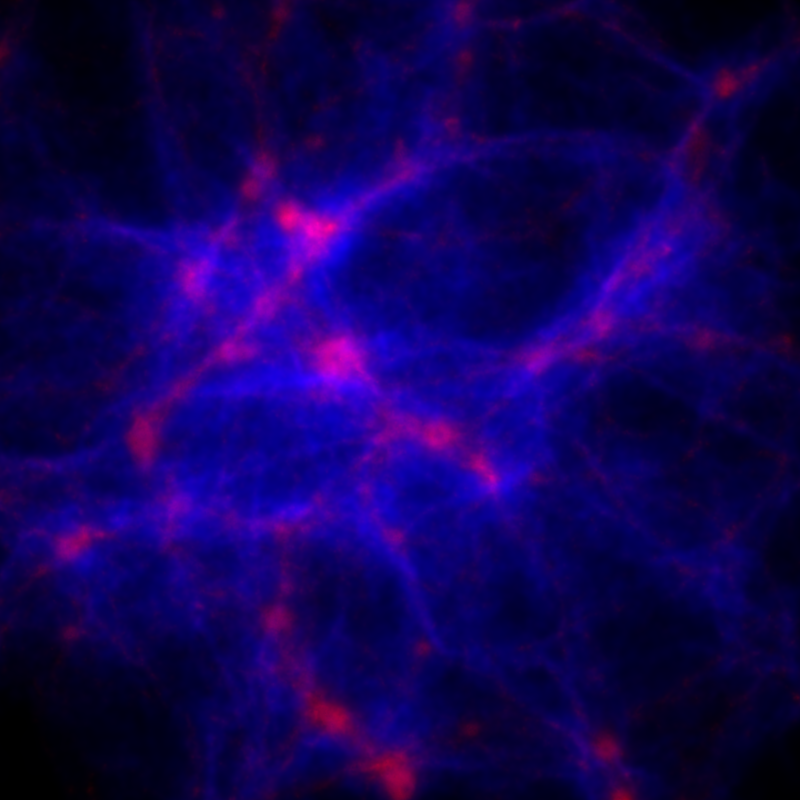

In [4]:
im = Image.fromarray(RGB, 'RGB')
im

In [5]:
im.save('is_this_volume_rendering.png')